In [329]:
import numpy as np
from numpy.typing import NDArray
from numpy import float_
import matplotlib.pyplot as plt
from time import time

In [310]:
def get_next_t_path_idx(t_grid):
    if isinstance(t_grid, np.int64):
        return None
    if t_grid.shape[0] <= 2:
        return None
    return np.argmin(np.abs(t_grid - (t_grid[-1] + t_grid[0]) / 2))

In [311]:
def get_path_recursion(t_grid: NDArray[float_], t_path_idx: dict, start_idx: int =0):
    next_t_path_idx = get_next_t_path_idx(t_grid)
    if not next_t_path_idx is None:
        t_path_idx[start_idx + next_t_path_idx] = {
            "idx_left": start_idx,
            "idx_right": start_idx + t_grid.shape[0] - 1,
            "weight_left": (t_grid[-1] - t_grid[next_t_path_idx]) / (t_grid[-1] - t_grid[0]),
            "weight_right": (t_grid[next_t_path_idx] - t_grid[0]) / (t_grid[-1] - t_grid[0]),
            "std": np.sqrt((t_grid[-1] - t_grid[next_t_path_idx]) * (t_grid[next_t_path_idx] - t_grid[0]) / (t_grid[-1] - t_grid[0]))
        }
        get_path_recursion(t_grid[:next_t_path_idx+1], t_path_idx, start_idx)
        get_path_recursion(t_grid[next_t_path_idx:], t_path_idx, start_idx+next_t_path_idx)

In [312]:
# t_grid = np.array([0, 1, 4, 5, 6, 8, 10])

In [313]:
def get_path(t_grid: NDArray[float_]):
    t_path_idx = {}
    get_path_recursion(t_grid, t_path_idx)
    return t_path_idx


In [380]:
size = 10_000
t_grid = np.arange(0, 100)

t_grid = np.concatenate([[-1000, -900, -100], t_grid]) + 1000

dim = 2
rng = np.random.default_rng(seed=0xBEDABEDA)


t0 = time()
t_path = get_path(t_grid)
print(time() - t0)

0.0012502670288085938


In [381]:
t0 = time()
W = np.zeros((size, dim, t_grid.shape[0]))
B = rng.normal(size=(size, dim, t_grid.shape[0]))

W[:, :, -1] = np.sqrt(t_grid[-1]) * B[:, :,-1]
for i in list(t_path.keys()):
    W[:, :, i] = (t_path[i]["weight_left"] * W[:, :, t_path[i]["idx_left"]] +
                  t_path[i]["weight_right"] * W[:, :, t_path[i]["idx_right"]] +
                  t_path[i]["std"] * B[:, :, i])
print(time() - t0)

0.07855534553527832


In [382]:
np.mean(W**2, axis=0).mean(axis=0)

array([   0.        ,  100.50869116,  897.92846487,  993.72295028,
        995.06669727,  995.55909033,  996.00680047,  996.6419294 ,
        997.54869237,  999.19164188, 1000.26602628, 1001.36231094,
       1002.44029497, 1003.13064037, 1004.39574207, 1006.40816548,
       1007.66310129, 1009.2143828 , 1010.30460399, 1011.51225047,
       1012.29906711, 1012.87071819, 1013.97825078, 1014.75396676,
       1015.64969018, 1017.49761156, 1018.94185814, 1019.80195587,
       1020.1514622 , 1021.45395416, 1022.11042793, 1022.54647096,
       1023.7553814 , 1024.27084099, 1025.85848223, 1026.80040898,
       1028.19309945, 1029.01351386, 1030.52344195, 1031.97001162,
       1032.5919131 , 1034.06227543, 1034.86094165, 1035.92843829,
       1036.45255554, 1037.19273473, 1037.99952529, 1039.16253071,
       1041.06876641, 1042.18925901, 1043.11882083, 1044.24548651,
       1045.40914869, 1046.67830842, 1047.67309878, 1048.20151769,
       1048.69750485, 1049.6322381 , 1050.10008509, 1050.86535

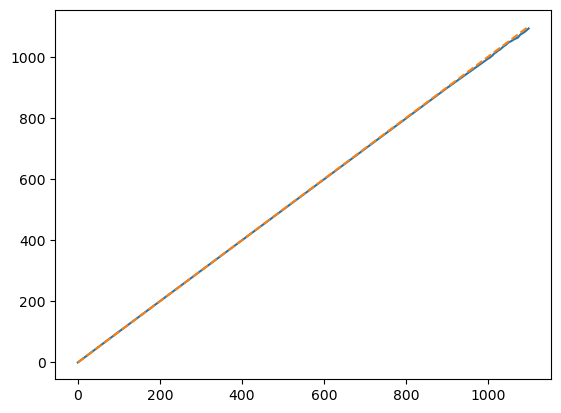

In [384]:
plt.plot(t_grid, np.mean(W**2, axis=0).mean(axis=0))
plt.plot(t_grid, t_grid, "--")

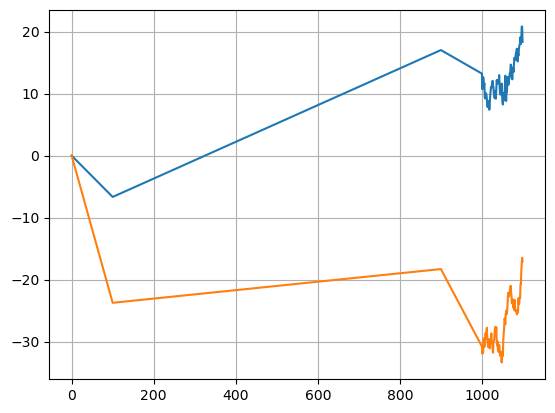

In [385]:
plt.plot(t_grid, W[0, :, :].T)
# plt.plot(t_grid, W[0, :])
# plt.plot(t_grid, W[2, :])
plt.grid()